# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [58]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person', root_dir="/mnt/storage/Datasets/folktables")
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
groups

,SEX,RAC1P
0,1,1
1,1,1
2,1,1
3,2,1
4,1,1
...,...,...
129558,1,1
129559,2,1
129560,1,1
129561,1,1


In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(features, labels, groups, test_size=0.1, random_state=0)


In [61]:
#######
# YOUR CODE
#######
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
#groups
from sklearn.model_selection import cross_val_score

numeric_features = ["AGEP","WKHP", "PWGTP"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(features,labels.values.ravel())

cv = KFold(n_splits=(100))
scores = cross_val_score(clf, features, labels.values.ravel(), cv = cv)
print(scores)

[0.7385969  0.80836613 0.80844331 0.81699599 0.81336832 0.81105279
 0.80935474 0.80541834 0.81375425 0.80541834]


<Axes: ylabel='Count'>

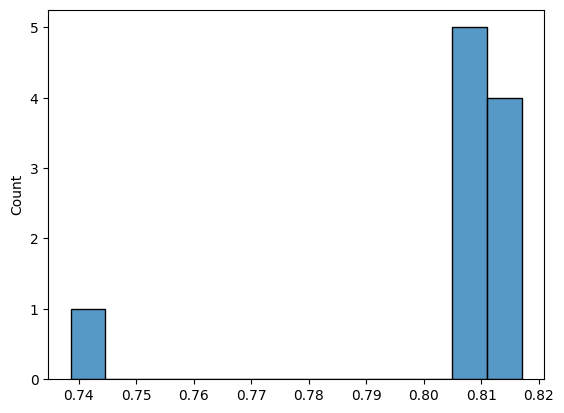

In [62]:
import seaborn as sns

sns.histplot(scores)

1
2


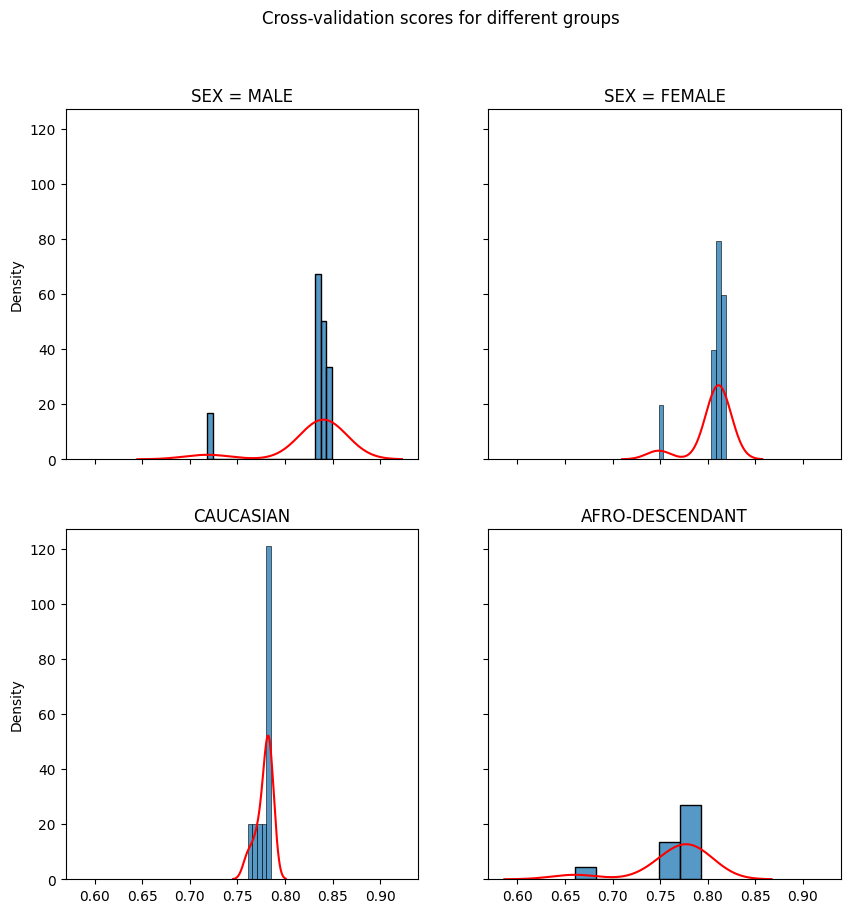

In [63]:
# score when split the dataset
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)

for i in range(1,3):
    print(i)
    score_sex = cross_val_score(clf, features.loc[groups[groups["SEX"] == i].index.tolist()], 
                                labels.loc[groups[groups["SEX"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    score_race = cross_val_score(clf, features.loc[groups[groups["RAC1P"] == i].index.tolist()], 
                                labels.loc[groups[groups["RAC1P"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    
    sns.histplot(score_sex, ax=ax[i-1, 0], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_sex, ax=ax[i-1, 0], color="red")
    sns.histplot(score_race, ax=ax[i-1, 1], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_race, ax=ax[i-1, 1], color="red")

ax[0,0].set_title("SEX = MALE")
ax[0,1].set_title("SEX = FEMALE")


ax[1,0].set_title("CAUCASIAN")
ax[1,1].set_title("AFRO-DESCENDANT")


plt.suptitle("Cross-validation scores for different groups")
plt.show()


In [64]:
scaler = StandardScaler()

features_scaled = scaler.fit_transform(features)

features_p = pd.DataFrame(features_scaled[:,54:], columns = features.columns[54:])

features_np = pd.DataFrame(features_scaled[:,:54], columns = features.columns[:54])

In [65]:
from scipy.linalg import orth

def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np.apply(lambda X: X - X.dot(orthbasis).dot(orthbasis.T))

    # Return debiased nonprotected features
    return Xs_np_debiased

features_np_debiased = debias_features(features_np, features_p)
features_debiased = pd.concat([features_np_debiased, features_p], axis=1)

In [66]:
features_debiased

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,-1.504244,-1.525045,-0.695776,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,4.610708,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
1,1.379906,-2.425334,-0.950025,-1.352836,3.620304,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
2,-0.717658,-0.024564,-0.682394,0.713439,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
3,-1.680683,-1.301046,0.077974,-1.235015,3.438780,-0.096363,-0.38317,-0.163429,-0.302095,-0.261444,...,-0.106427,-0.094215,-0.037545,-0.963585,-0.071533,-0.07375,-0.079782,-0.178291,1.067335,-0.265924
4,-1.110951,0.725677,-1.083841,-1.352836,-0.197754,5.922601,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.527771,-0.774805,-0.013317,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,3.063066,-0.172806,...,-0.115629,-0.111205,-0.025243,1.024056,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
129559,0.679076,-0.025637,0.265316,0.831259,-0.379278,-0.096363,-0.38317,-0.163429,-0.302095,-0.261444,...,-0.106427,-0.094215,-0.037545,-0.963585,10.778907,-0.07375,-0.079782,-0.178291,1.067335,-0.265924
129560,0.331124,-0.024564,-0.789447,0.713439,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,1.024056,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
129561,-0.193267,3.726639,1.137495,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,3.063066,-0.172806,...,8.755036,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924


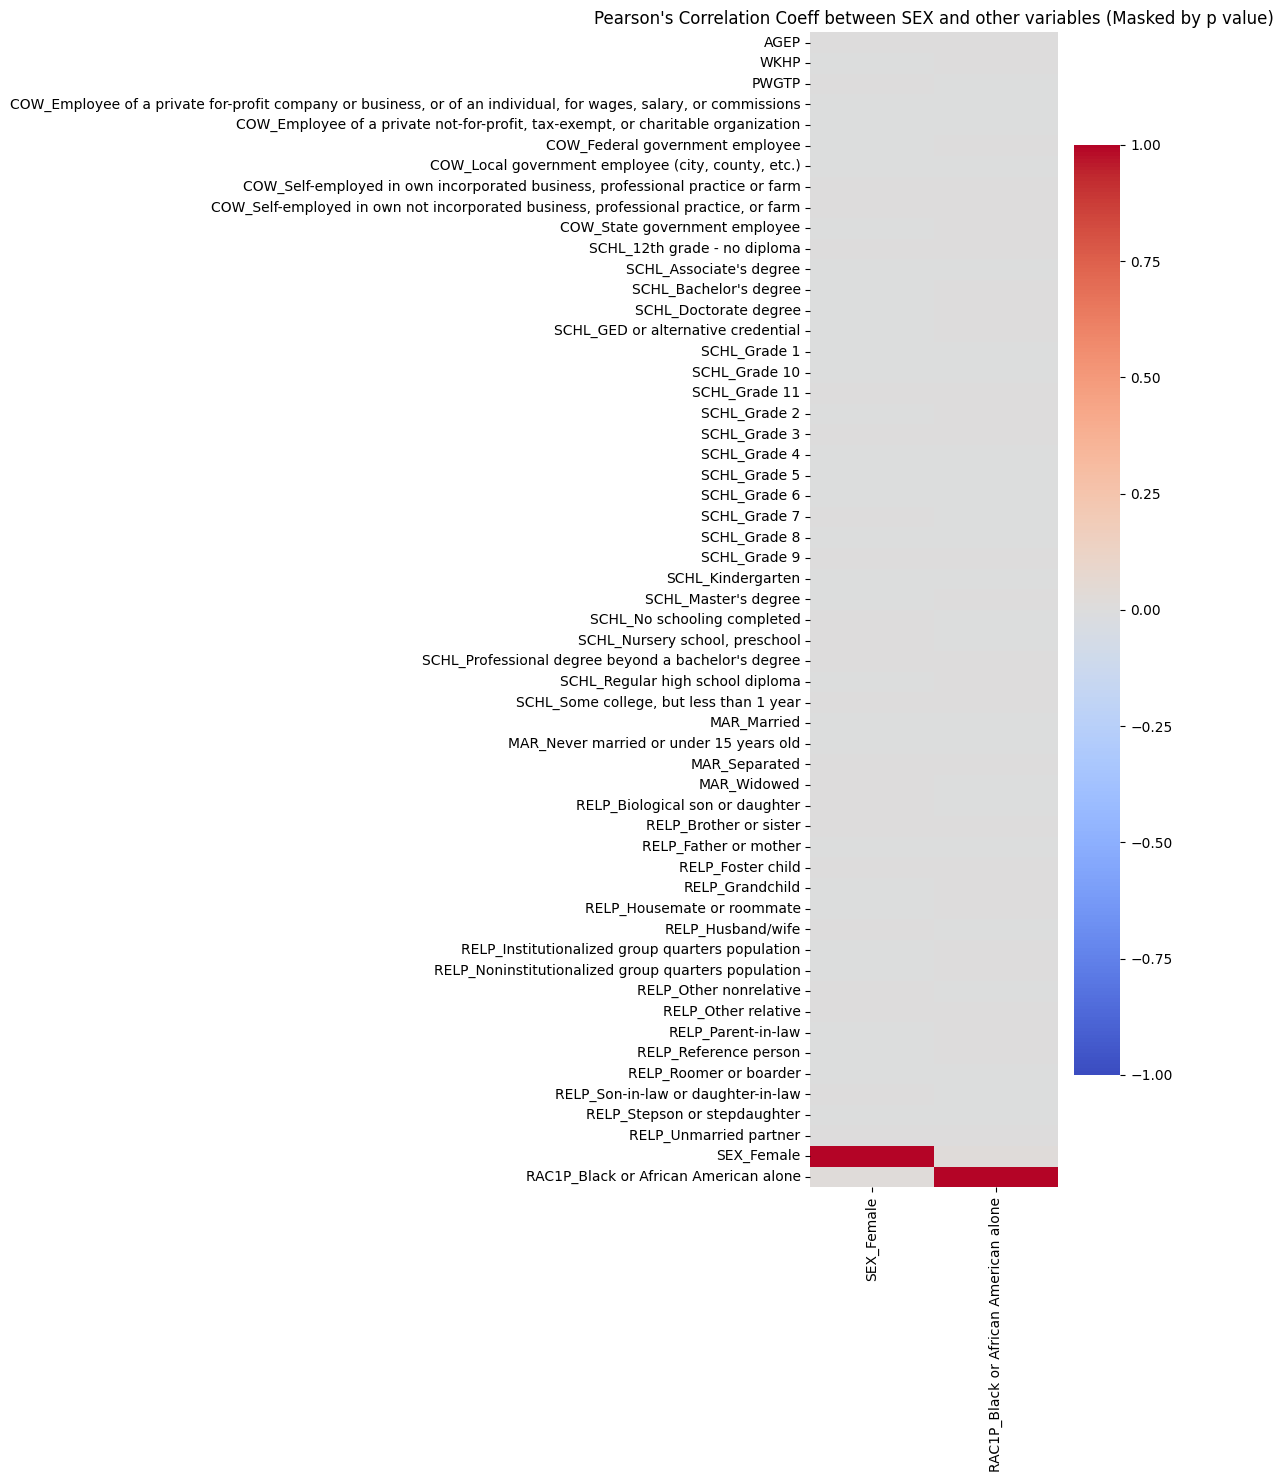

In [67]:
from scipy.stats import pearsonr

# Compute correlation matrix
corr_ = features_debiased.corr()

# Plot correlations with protected features
plt.figure(figsize=(4,15))
sns.heatmap(corr_.iloc[:,54:], cmap="coolwarm", xticklabels=features.columns[54:], yticklabels=features.columns, vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

In [68]:
features_debiased.iloc[:,54]*0.1

0        -0.093691
1        -0.093691
2        -0.093691
3         0.106733
4        -0.093691
            ...   
129558   -0.093691
129559    0.106733
129560   -0.093691
129561   -0.093691
129562   -0.093691
Name: SEX_Female, Length: 129563, dtype: float64

In [ ]:
def fair_debiasing(x_d, x_np, lambd_=0):
    x_fair = x_d + lambd_ * (x_np - x_d)
    return x_fair

feautues_np_debiased_fair = fair_debiasing(features_np_debiased, features_np, lambd_=0.1)

features_debiased_fair = pd.concat([feautues_np_debiased_fair, features_p], axis=1)
features_debiased_fair

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,-1.502723,-1.507422,-0.695965,-1.346822,-0.206266,-0.199617,-0.231292,-0.263632,-0.352748,4.606080,...,-0.115487,-0.110897,-0.025738,-0.976185,-0.105515,-0.105830,-0.071287,-0.200515,-0.936913,-0.265924
1,1.381427,-2.407710,-0.950214,-1.346822,3.611792,-0.199617,-0.231292,-0.263632,-0.352748,-0.177434,...,-0.115487,-0.110897,-0.025738,-0.976185,-0.105515,-0.105830,-0.071287,-0.200515,-0.936913,-0.265924
2,-0.716137,-0.006940,-0.682583,0.719453,-0.206266,-0.199617,-0.231292,-0.263632,-0.352748,-0.177434,...,-0.115487,-0.110897,-0.025738,-0.976185,-0.105515,-0.105830,-0.071287,-0.200515,-0.936913,-0.265924
3,-1.681183,-1.320827,0.072671,-1.240784,3.448421,-0.103511,-0.375607,-0.168375,-0.304184,-0.257208,...,-0.107204,-0.095605,-0.036809,-0.964227,-0.073676,-0.075409,-0.079352,-0.179683,1.067335,-0.265924
4,-1.109430,0.743300,-1.084029,-1.346822,-0.206266,5.926131,-0.231292,-0.263632,-0.352748,-0.177434,...,-0.115487,-0.110897,-0.025738,-0.976185,-0.105515,-0.105830,-0.071287,-0.200515,-0.936913,-0.265924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.529292,-0.757181,-0.013506,-1.346822,-0.206266,-0.199617,-0.231292,-0.263632,3.066374,-0.177434,...,-0.115487,-0.110897,-0.025738,1.024743,-0.105515,-0.105830,-0.071287,-0.200515,-0.936913,-0.265924
129559,0.678576,-0.045418,0.260012,0.825491,-0.369637,-0.103511,-0.375607,-0.168375,-0.304184,-0.257208,...,-0.107204,-0.095605,-0.036809,-0.964227,10.776765,-0.075409,-0.079352,-0.179683,1.067335,-0.265924
129560,0.332645,-0.006940,-0.789635,0.719453,-0.206266,-0.199617,-0.231292,-0.263632,-0.352748,-0.177434,...,-0.115487,-0.110897,-0.025738,1.024743,-0.105515,-0.105830,-0.071287,-0.200515,-0.936913,-0.265924
129561,-0.191746,3.744262,1.137307,-1.346822,-0.206266,-0.199617,-0.231292,-0.263632,3.066374,-0.177434,...,8.755179,-0.110897,-0.025738,-0.976185,-0.105515,-0.105830,-0.071287,-0.200515,-0.936913,-0.265924


In [70]:
cv = KFold(n_splits=(10))
score_list = []
lambda_list = []
for i in np.linspace(0, 1, 10):
    lambda_list.append(i)
    log_r = LogisticRegression()
    features_debiased_fair = fair_debiasing(features_np_debiased, features_np, lambd_=i)
    log_r.fit(features_debiased_fair, labels.values.ravel())
    score_list.append(cross_val_score(log_r, features_debiased_fair, labels.values.ravel(), cv = cv).mean())

/home/thejarmanitor/miniconda3/envs/algfair/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


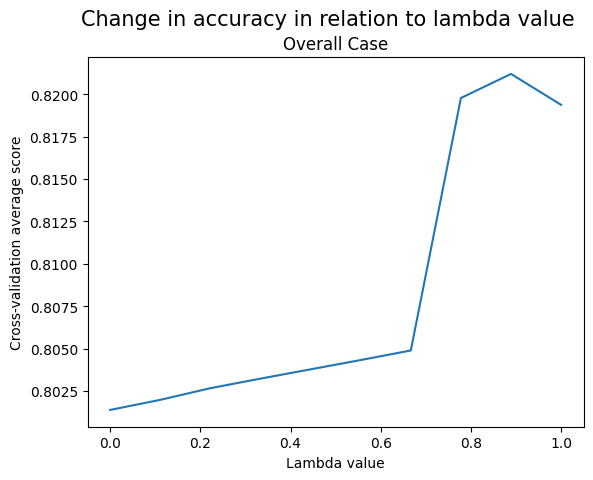

In [71]:
plt.plot(lambda_list, score_list)
plt.xlabel("Lambda value")
plt.ylabel("Cross-validation average score")
plt.suptitle("Change in accuracy in relation to lambda value", size=15)
plt.title("Overall Case")
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)

for i in range(1,3):
    print(i)
    score_sex = cross_val_score(clf, features.loc[groups[groups["SEX"] == i].index.tolist()], 
                                labels.loc[groups[groups["SEX"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    score_race = cross_val_score(clf, features.loc[groups[groups["RAC1P"] == i].index.tolist()], 
                                labels.loc[groups[groups["RAC1P"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    
    sns.histplot(score_sex, ax=ax[i-1, 0], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_sex, ax=ax[i-1, 0], color="red")
    sns.histplot(score_race, ax=ax[i-1, 1], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_race, ax=ax[i-1, 1], color="red")

ax[0,0].set_title("SEX = MALE")
ax[0,1].set_title("SEX = FEMALE")


ax[1,0].set_title("CAUCASIAN")
ax[1,1].set_title("AFRO-DESCENDANT")


plt.suptitle("Cross-validation scores for different groups")
plt.show()